# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import TensorFlowV2Classifier

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Model

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation="relu"),
    Dense(10)
])

In [6]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train

In [7]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 9s 14ms/step - loss: 1.4344 - accuracy: 0.4839 - val_loss: 1.1077 - val_accuracy: 0.6104
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 0.9356 - accuracy: 0.6712 - val_loss: 0.8825 - val_accuracy: 0.6931
Epoch 3/10
391/391 [==============================] - 5s 12ms/step - loss: 0.7255 - accuracy: 0.7465 - val_loss: 0.7775 - val_accuracy: 0.7352
Epoch 4/10
391/391 [==============================] - 5s 12ms/step - loss: 0.5749 - accuracy: 0.7992 - val_loss: 0.7363 - val_accuracy: 0.7468
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 0.4403 - accuracy: 0.8477 - val_loss: 0.7189 - val_accuracy: 0.7558
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 0.3061 - accuracy: 0.8937 - val_loss: 0.8569 - val_accuracy: 0.7553
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 0.2025 - accuracy: 0.9299 - val_loss: 0.8718 - val_accuracy: 0.7588

In [8]:
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=CategoricalCrossentropy(from_logits=True),
    nb_classes=10,
    input_shape=(32, 32, 3),
)

# Attack

In [11]:
attack = BasicIterativeMethod(estimator=classifier, eps=0.3, eps_step=0.01, max_iter=10)

In [12]:
adv_test = attack.generate(x=x_test[:100])

PGD - Batches: 0it [00:00, ?it/s]

# Results

In [13]:
y_pred = model.predict(x_test[:100], verbose=0)

In [14]:
adv_pred = model.predict(adv_test, verbose=0)

In [15]:
y_pred = np.argmax(y_pred, axis=1)

In [16]:
adv_pred = np.argmax(adv_pred, axis=1)

In [17]:
y_test = np.argmax(y_test[:100], axis=1)

In [18]:
print("Original Accuracy Score:", np.sum(adv_pred == y_test) / len(y_test))
print("Adversarial Accuracy Score:", np.sum(y_pred == y_test) / len(y_test))

Original Accuracy Score: 0.13
Adversarial Accuracy Score: 0.81


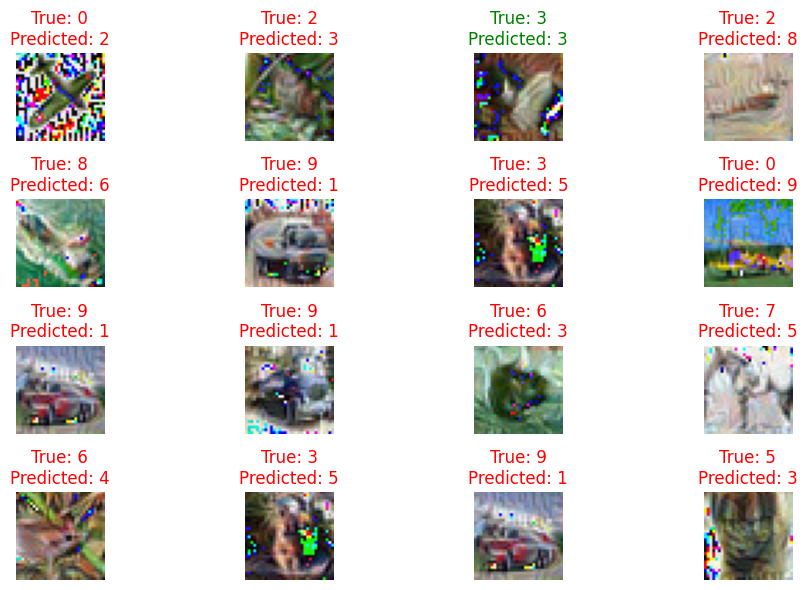

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow((adv_test[random_index[i]] * 255).astype(np.uint8))
    ax.axis('off')

    if y_test[random_index[i]] == adv_pred[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_pred[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()